In [1]:
from unityagents import UnityEnvironment
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import RAdam

from agent import MADDPG
from OUNoise_Buffer import ReplayBuffer, OUNoise


%matplotlib inline

%load_ext autoreload
%autoreload 2

cuda:0


In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [10]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


In [5]:
def learner(agent, n_episodes=200, max_t=500000, max_t_slices=1, print_every=100, train_mode=True):

    scores = []
    scores_window = deque(maxlen=100)              # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    t_slice = max_t // max_t_slices
    t = t_slice
    
    for i_episode in range(1, n_episodes+1):
        both_scores = []
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent
        
        start_time = time.time()
        t += t_slice
        if t > max_t:
            t = t_slice
        for t in range(t):
            actions = agent.act(states)            
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            both_scores.append(rewards)      
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        episode_reward = np.max(np.sum(np.array(both_scores),axis=0))
        scores.append(episode_reward)
        scores_window.append(episode_reward)         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
        
        print('\rEpisode {}\tScore: {:.3f}\tMoving Average: {:.3f}'.format(i_episode, episode_reward, moving_avgs[-1]),end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, moving_avgs[-1]))
            
                  
        if moving_avgs[-1] >= 0.5:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average: {:.3f}'.format(i_episode, moving_avgs[-1]))            
            if train_mode:
                agent.save_checkpoint() 
            break
            
    return scores, moving_avgs

In [6]:
scores, avgs = learner(MADDPG(update_every=1, update_num=2, 
                              noise_start=1.0, noise_decay=0.9999, t_noise_stop=1000), n_episodes=5000)

Episode 100	Average Score: 0.011Average: 0.011
Episode 200	Average Score: 0.045Average: 0.045
Episode 300	Average Score: 0.016Average: 0.016
Episode 400	Average Score: 0.003Average: 0.003
Episode 500	Average Score: 0.007Average: 0.007
Episode 600	Average Score: 0.018Average: 0.018
Episode 700	Average Score: 0.088Average: 0.088
Episode 800	Average Score: 0.096Average: 0.096
Episode 900	Average Score: 0.114Average: 0.114
Episode 1000	Average Score: 0.126Average: 0.126
Episode 1100	Average Score: 0.166Average: 0.166
Episode 1200	Average Score: 0.250Average: 0.250
Episode 1299	Score: 1.000	Moving Average: 0.504
Environment SOLVED in 1299 episodes!	Moving Average: 0.504


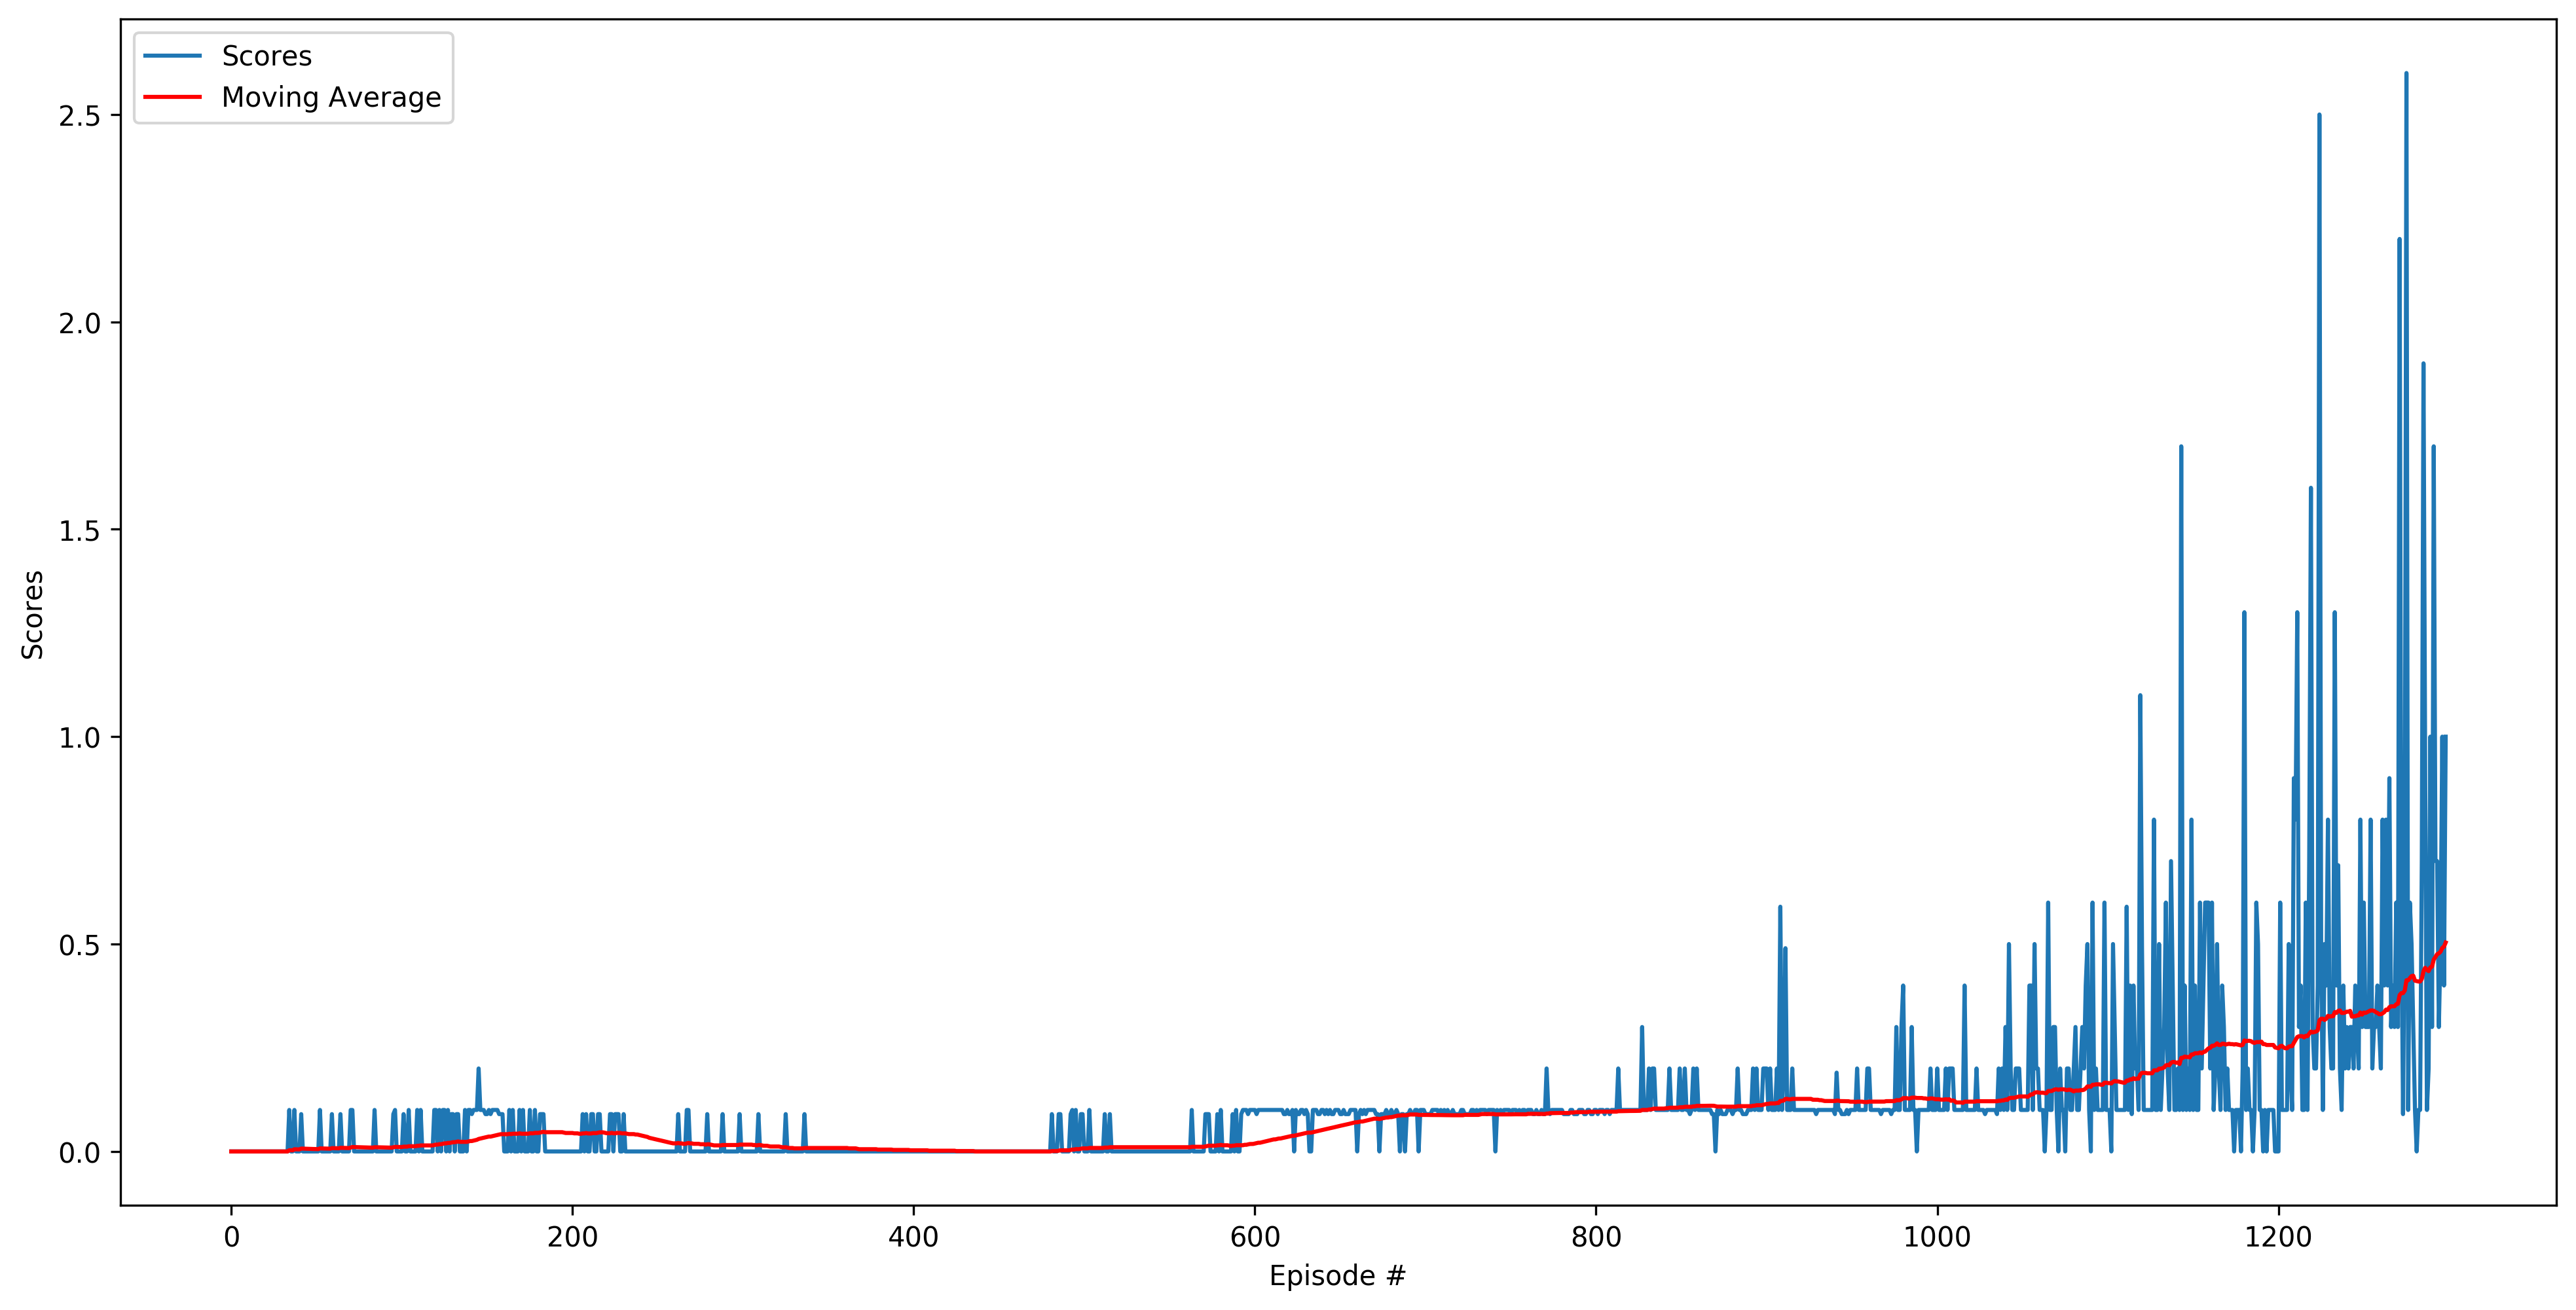

In [7]:
fig = plt.figure(figsize=(16,8),dpi=300)
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving Average')
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [ ]:
env.close()